# M09. Serial and Parallel Processing

Rather loosely, *serial processing* describes a type of computation in which tasks are performed one after another, whereas *parallel processing* refers to the dual paradigm: tasks are performed concurrently by multiple *worker processes* with varying degrees of interdependence (and which hence require varying degrees of coordination). Serial programs are easier to write than parallel programs. Any endeavor to parallelize a computation should likely be backed by the possibility of marked improvements in latency (including *overhead*) as otherwise, the effort would be hardly worthwhile.      

Certain problems are more amenable to parallelization than others, requiring minimal effort to divide into smaller tasks. In the extreme, such workloads are called *embarassingly-parallel*.

A notable example of an embarassingly-parallel workload is *Monte Carlo Simulation*. In particular, using the Monte Carlo method of computing $\pi$, we will demonstrate the (best case) speedups afforded by parallelization.

It is well known that the value of $\pi$ may be estimated by picking random points from within the unit square, and then counting the fraction of points found to lie within the first quadrant of the unit circle. Slightly more formally, a point $(x,y)$ drawn uniformly from $[0,1]^2$ has a $\frac{\pi}{4}$ probability of being within a Euclidean distance of $1$ from the origin. The Monte Carlo method exploits this quality as follows: 

- Call the drawing of a random point an independent *experiment*.
- Of a sufficiently large number of such experiments $N$, count the number $N_{Hit}$ which fall within distance $1$ of (0,0). 
- Then, $$\frac{\pi}{4}\approx \frac{N_{Hit}}{N}$$ and $$\pi \approx \frac{4N_{Hit}}{N}.$$

This is a manifestly stupid way of estimating $\pi$ (convergence is abysmal), but it suffices for the task at hand. Parallelizing this process is trivial: instead of making one process perform $N$ experiments, we will spawn $p$ many processes that will each perfom $N / p$ experiments. 

We begin our implementation by creating a *workers* module dedicated to a *worker* function:

```python
import numpy as np

def worker(iterations):
    """
    Generate desired number of random 2-tuples drawn uniformly from [0,1]^2
    Take L2 norm (distance from origin) of each tuple
    Use Boolean mask to count number of points within unit circle
    Return count
    """
    simulations = np.linalg.norm(np.random.rand(iterations,2), axis = 1) 
    return np.count_nonzero(simulations < 1)
```

Back in main, we define serial and parallel versions of the Monte Carlo method (both using our worker function):

In [2]:
import multiprocessing as mp
import workers

def serial(iterations):
    """
    Normalize count by total iterations and multiply by 4
    Return pi estimate
    """
    return 4*(workers.worker(iterations)/iterations)

def multiprocess(iterations, num_workers):
    """
    Spawn num_workers-many processes
    Create a pool, or a 'work-crew'
    Assign each worker to simulating a portion of the total number of experiments
    Retrieve each worker's count and sum to obtain a global count 
    Normalize global count by total iterations and multiply by 4
    Return pi estimate
    """
    pool = mp.Pool(processes = num_workers)
    results = pool.map(workers.worker, [int(iterations/num_workers)]*num_workers)
    return 4*(sum(results)/iterations)

We verify that this actually works:

In [22]:
print(serial(1000000))
print(multiprocess(1000000,2))

3.140424
3.14258


(We've also verified that this is an awful way of getting to $\pi$&mdash;in fact, we'd be better-off computing the Taylor expansion of the inverse tangent of 1, the so-called Gregory-Leibniz Series.)

Let's benchmark our results between serial and parallel implementations (here, with 2, 4, and 8 concurrent processes):

In [3]:
"""
Diagnostics code from Sebastian Raschka at 
https://sebastianraschka.com/Articles/2014_multiprocessing.html#kernel-density-estimation-as-benchmarking-function
"""

import timeit

benchmarks = []
sim_count = 100000000 # total number of experiments

benchmarks.append(timeit.Timer('serial(sim_count)',
    'from __main__ import serial, sim_count').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(sim_count, 2)',
    'from __main__ import multiprocess, sim_count').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(sim_count, 4)',
    'from __main__ import multiprocess, sim_count').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(sim_count, 8)',
    'from __main__ import multiprocess, sim_count').timeit(number=1))

For posterity, it's best to also dump our system details:

In [4]:
"""
Code from Sebastian Raschka at 
https://sebastianraschka.com/Articles/2014_multiprocessing.html#kernel-density-estimation-as-benchmarking-function
"""

import platform

def dump_sys():
    print('\nPython version\t:', platform.python_version())
    print('compiler\t:', platform.python_compiler())
    print('\nsystem\t\t:', platform.system())
    print('machine\t\t:', platform.machine())
    print('processor\t:', platform.processor())
    print('CPU count\t:', mp.cpu_count())

Finally, we plot our results as follows

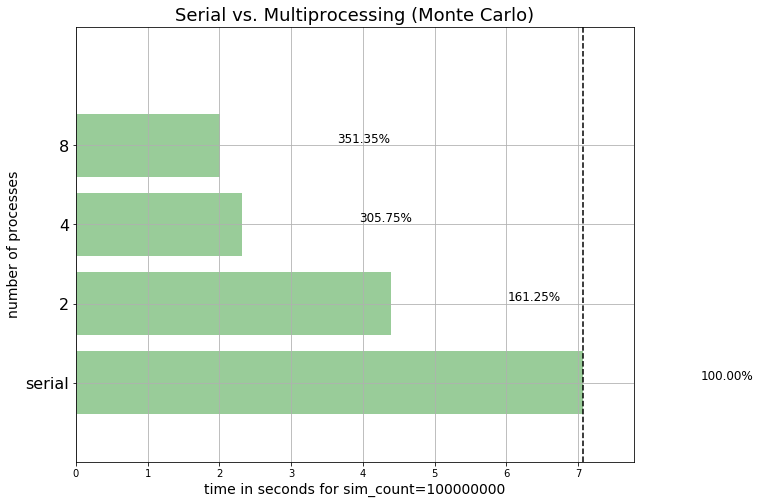


Python version	: 3.7.4
compiler	: MSC v.1915 64 bit (AMD64)

system		: Windows
machine		: AMD64
processor	: Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU count	: 8


In [6]:
"""
Code from Sebastian Raschka at 
https://sebastianraschka.com/Articles/2014_multiprocessing.html#kernel-density-estimation-as-benchmarking-function
"""

from matplotlib import pyplot as plt
import numpy as np

def plot_results():
    bar_labels = ['serial', '2', '4', '8']

    fig = plt.figure(figsize=(10,8))

    # plot bars
    y_pos = np.arange(len(benchmarks))
    plt.yticks(y_pos, bar_labels, fontsize=16)
    bars = plt.barh(y_pos, benchmarks,
             align='center', alpha=0.4, color='g')

    # annotation and labels

    for ba,be in zip(bars, benchmarks):
        plt.text(ba.get_width() + 2, ba.get_y() + ba.get_height()/2,
                '{0:.2%}'.format(benchmarks[0]/be),
                ha='center', va='bottom', fontsize=12)

    plt.xlabel('time in seconds for sim_count=%s' %sim_count, fontsize=14)
    plt.ylabel('number of processes', fontsize=14)
    t = plt.title('Serial vs. Multiprocessing (Monte Carlo)', fontsize=18)
    plt.ylim([-1,len(benchmarks)+0.5])
    plt.xlim([0,max(benchmarks)*1.1])
    plt.vlines(benchmarks[0], -1, len(benchmarks)+0.5, linestyles='dashed')
    plt.grid()
    plt.show()

plot_results()
dump_sys()

It is apparent that there are significant benefits to parallelization: with just two processes, a speedup of more than 1.5x over the serial version of Monte Carlo is achieved. It is also apparent that there are diminishing returns to increasing parallelization (in fact, on this computer, overhead really began to kick-in beyond eight processes).